# <b>Introduction to Statistical Learning, 2nd Edition</b>
## by James, Witten, Hastie, Tibshirani

### Notes by Melis Tekant

## Chapter 4  - Classification 

What if the response variable is qualitative? In this case, we might want to perform classification of response, instead of quantitative regression. Some widely used classifiers are logistic regression, linear discriminant analysis, quadratic discriminant analysis, naive Bayes, and KNN. More complex and computer-intensive classification methods will be discussed in later chapters (Chs 7,8,9). 

In [607]:
import pandas as pd
import numpy as np
import matplotlib as mpl
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import norm

In [3]:
default = pd.read_csv('/Users/melistekant/Documents/Python Projects/ISLR2/Default.csv')
default.head()


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


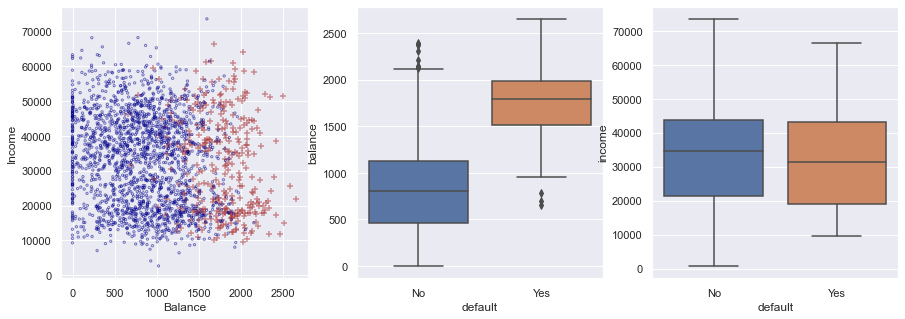

In [93]:
fig,axs = plt.subplots(1,3,figsize = (15,5))
defaulted = default[default['default']=='Yes']
notdef = default[default['default']=='No']
plt.subplot(1,3,1)
plt.scatter(defaulted['balance'],defaulted['income'],marker ='+',color='brown',alpha=0.5)
plt.scatter(notdef['balance'][::5],notdef['income'][::5],facecolor='None',edgecolor='darkblue',alpha=0.5,s=5)
plt.xlabel('Balance')
plt.ylabel('Income');

plt.subplot(1,3,2)
sns.boxplot(x='default',y='balance',data=default)
sns.set(rc = {'figure.figsize':(5,5)})

plt.subplot(1,3,3)
sns.boxplot(x='default',y='income',data=default)
sns.set(rc = {'figure.figsize':(5,5)})


#### Logistic regression:

Logistic regression models the probabiliy that Y belongs to a certain category. For the above data, this would be P(default = 'Yes' | balance) = p(balance). Although the prediction default = Yes will be made for p(balance) >0.5, for certain uses (say giving out a loan), a lower threshold can be chosen, e.g. p(balance) >0.1.

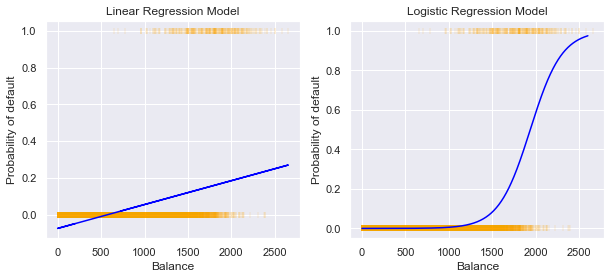

In [157]:
from sklearn.linear_model import LinearRegression
yndict = {'Yes':1,'No':0}
regress = LinearRegression()
X = default[['balance']]
y = default[['default']].applymap(lambda x: yndict[x])
regress = LinearRegression()
regress.fit(X,y)
y_pred = regress.predict(X)

plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X,y,marker='|',c='orange',alpha=0.1)
plt.plot(X,y_pred,color = 'blue')
plt.xlabel('Balance')
plt.ylabel('Probability of default')
plt.title('Linear Regression Model')

from sklearn.linear_model import LogisticRegression

xlin = np.linspace(0,2600,1000)
logreg = LogisticRegression(random_state=0)
logreg.fit(X,np.ravel(y))
y_predlog = logreg.predict_proba(xlin[:,np.newaxis])

plt.subplot(1,2,2)
plt.scatter(X,y,marker='|',c='orange',alpha=0.1)
plt.plot(xlin,y_predlog[:,1],color = 'blue')
plt.xlabel('Balance')
plt.ylabel('Probability of default')
plt.title('Logistic Regression Model');

Logistic regression model has output that can take on values between 0 and 1 for all input values. The function used is:

$$ p(X) = \frac{e^{\beta_0 +\beta_1 X}}{1+e^{\beta_0 + \beta_1X}}$$

this method can be used when the output ranges between two decisions for all input values. The quantity $ \frac{p(X)}{1-p(X)} = e^{\beta_0 +\beta_1 X}$ is called odds, in the range $[0,\infty]$. 0/$\infty$ indicates very low/high probability of default. 

Log odds, or logit is attained by taking the log of the odds.

$$ \log{\frac{p(X)}{1-p(X)}} = \beta_0 +\beta_1 X $$

and is linear in X. Increasing X by one unit corresponds to a change in log odds by $\beta_1$. 

The coefficients $\beta_0, \beta_1$ are unknown and need to be estimated from the training data. Least squares can be used but maximum likelihood is generally prefered due to its favorable statistical properties. The likelihood function is 

$$ l(\beta_0,\beta_1) = \prod_{i:y_i=1} p(x_i) \prod_{i':y_{i'}=0} (1-p(x_{i'})) $$

and the esimates of the coefficients are made such that they maximize the likelihood function $l$. 

For the above example,


In [408]:
# Making a function that calculates the various values we'd like to calculate:
# coefficients, standard error, z-statistic, and p-values. 
# Warning: Only works for Logistic Regression

from scipy.stats import t

def logitstatvals(X,y,sigfig):

    logreg = LogisticRegression(random_state=0)
    logreg.fit(X,np.ravel(y))
    y_pred = logreg.predict_proba(X)
    inter = logreg.intercept_
    coeffs = logreg.coef_
    coeffs = coeffs.T

    X_design = np.hstack([np.ones((X.shape[0], 1)), X])
    V = np.diagflat(np.product(y_pred,axis = 1))
    covar = np.linalg.inv(X_design.T @ V @ X_design)

    sterrs = np.sqrt(np.diag(covar))
    
    z_b0 = inter/sterrs[0]
    z_b1 = coeffs.T/sterrs[1:]
    z_b1 = z_b1.T
    
    dof = np.shape(X)[0]-2
    pval_0 = 2*(1 - t.cdf(abs(z_b0), dof))
    pval_1 = 2*(1 - t.cdf(abs(z_b1), dof))
    pval_1 = np.array(pval_1)
    
    d = {0: ["Intercept", inter, sterrs[0], z_b0, pval_0]}
    for i in range(0,len(sterrs)-1):
        d[i+1] = [X.columns[i], coeffs[i], sterrs[1+i],z_b1[i],pval_1[i]]
    print ("{:<12} {:<12} {:<12} {:<12} {:<12}".format("Parameter",'Coefficient','Std. Error','z-statistic','p-value'))
    for k, v in d.items():
        name, coef,std,tstat,pval = v
        print ("{:<12} {:<12} {:<12} {:<12} {:<12}".format(name,round(float(coef),sigfig),round(float(std),sigfig),round(float(tstat),sigfig),round(float(pval),sigfig)))



In [435]:
X = default[['balance']]
yndict = {'Yes':1,'No':0}
y = default[['default']].applymap(lambda x: yndict[x])

logitstatvals(X,y,5)

Parameter    Coefficient  Std. Error   z-statistic  p-value     
Intercept    -10.65133    0.36117      -29.49129    0.0         
balance      0.0055       0.00022      24.95241     0.0         


Note on z-statistic: It is the analogous variable for t-statistic used in linear regression. (z-statistic = $\hat \beta_1 / SE(\hat \beta_1)$. A large z-statistic serves as strong evidence against the null hypothesis. 



In [436]:
yndict = {'Yes':1,'No':0}
X = default[['student']].applymap(lambda x: yndict[x])
y = default[['default']].applymap(lambda x: yndict[x])
logitstatvals(X,y,4)

Parameter    Coefficient  Std. Error   z-statistic  p-value     
Intercept    -3.5021      0.0706       -49.5724     0.0         
student      0.3996       0.1151       3.4722       0.0005      


Let's try multiple logistic regression now.

In [521]:
yndict = {'Yes':1,'No':0}
y = default[['default']].applymap(lambda x: yndict[x])
x1 = default[['balance']]
x2 = default[['income']]
x3 = default[['student']].applymap(lambda x: yndict[x])
X = pd.concat([x1,x2,x3],axis=1)
pval = logitstatvals(X,y,4)

Parameter    Coefficient  Std. Error   z-statistic  p-value     
Intercept    -2.9508      0.2814       -10.4845     0.0         
balance      0.0041       0.0002       24.5182      0.0         
income       -0.0001      0.0          -16.9744     0.0         
student      -3.8901      0.2091       -18.6041     0.0         


Taking a look at whether the fact that a person is a student affects their likelihood of defaulting compared to a non-student, given that they have the same credit card balance. 

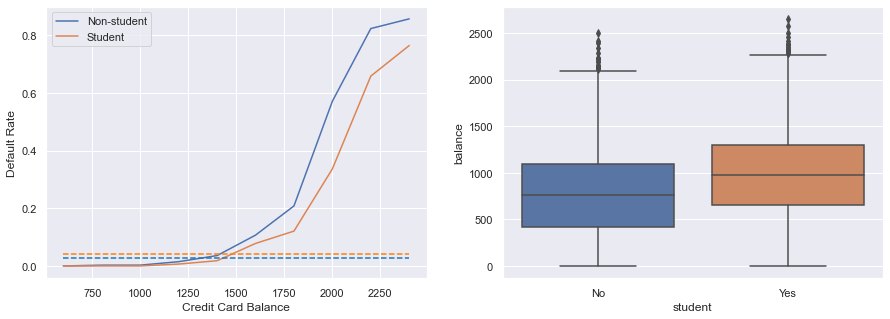

In [522]:
datayes = default[default['student']=='Yes']
datano = default[default['student']=='No']
xes = np.linspace(400,2400,11)
yyes = datayes[['default']].applymap(lambda x: yndict[x])
yno = datano[['default']].applymap(lambda x: yndict[x])

aveyes = []
aveno = []
for i in range(0,len(xes)-1):
    aveyes.append(np.mean(yyes[(datayes['balance']>xes[i]) & (datayes['balance']<xes[i+1])]))
    aveno.append(np.mean(yno[(datano['balance']>xes[i]) & (datano['balance']<xes[i+1])]))

fig,axs = plt.subplots(1,2,figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(xes[1:],aveno,label='Non-student')
plt.plot(xes[1:],aveyes,label = 'Student')
plt.xlabel('Credit Card Balance')
plt.ylabel('Default Rate')
plt.legend()
plt.plot(xes[1:],np.mean(yno).values*np.ones(len(xes[1:])),color='tab:blue',linestyle='--')
plt.plot(xes[1:],np.mean(yyes).values*np.ones(len(xes[1:])),color='tab:orange',linestyle='--')


plt.subplot(1,2,2)
sns.boxplot(x='student',y='balance',data=default);

Yes, given a credit card balance, students are less likely to default than non-students. Generally students have higher balances, though, and thus their default rate is also higher on average. 

#### Multinomial logistic regression

The two-class logistic regression can be extended to K>2 classes using multinomial logistic regression. In order to perform this model, one class is selected as the baseline. The choice of baseline does not affect the results: the predictions, log odds between pairs of classes, and other key models. The coefficient estimates will differ, though, due to different baselines. 

An alternate coding is 'softmax'. In this coding, all K classes are treated symmetrically, instead of selecting a baseline class.

#### Generative Models

An alternative approach, where the distribution of the predictors are modeled for each response value, then using Bayes' theorem, the estimates are flipped around to uncover the conditional probability $P(Y=k|X=x)$.

This approach is useful and/or more accurate (when compared to logistic regression) when the separation between classes is large, the distribution of predictors is close to normal in each class, or the number of response classes is >2. 

Say we have K classes, then by Bayes' theorem,

$$ P(Y=k|X=x) = \frac{P(X=x|Y=k) \cdot P(Y=k)}{P(X=x)} $$

or in equivalent notation,

$$ p_k(x) = \frac{P(X=x|Y=k) \cdot P(Y=k)}{\sum_{l=1}^K P(X=x|Y=l) \cdot P(Y=l)} $$

If $f_k(x) = P(X=x|Y=k)$ is known, the Bayes classifier can be used (minimum error rate). There are multiple methods to estimate this value. The following will be discussed: linear discriminant analysis, quadratic discriminant analysis, and naive Bayes. 


#### Linear discriminant analysis

Say we have a single predictor. We assume $f_k(x)$ is normal, which for one dimension,

$$f_k(x) = \frac{1}{\sqrt{2 \pi} \sigma_k} e^{-\frac{1}{2\sigma^2_k}(x-\mu_k)^2}. $$

Assume all variances are equal ($\sigma_i =\sigma,$    $\forall i$) and denoting $\pi_k \equiv P(Y=k),$

$$ p_k(x) = \frac{ \pi_k \frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{1}{2\sigma^2}(x-\mu_k)^2}}{\sum_{l=1}^K \pi_l \frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{1}{2\sigma^2}(x-\mu_l)^2}}. $$

Taking the log of the above equation, Bayes' classifier assigns the observation to the class for which the below equation is maximized:

$$\delta_k(x) = x \frac{\mu_k}{\sigma^2}-\frac{\mu_k^2}{2\sigma^2} + log(\pi_k). $$

(For the linear discriminant function, the estimate $\hat \delta_k(x)$ is a linear function of $x$.)

For two classes with equal probability, the Bayes decision boundary takes on a simple equation $x =\frac{\mu_1+\mu_2}{2}.$

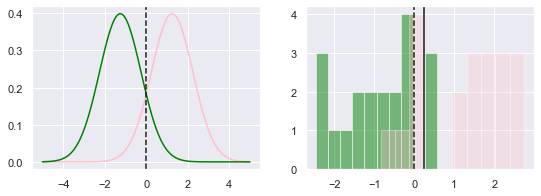

In [602]:
mu_1 = 1.25
mu_2 = -1.25
var = 1
x = np.linspace(-5, 5, 100)

#Plot normal distributions
fig = plt.subplots(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(x,stats.norm.pdf(x,mu_1,var),c='pink')
plt.plot(x,stats.norm.pdf(x,mu_2,var),c='green')
plt.axvline(x=0,c='k',linestyle='--')

left_pts = np.random.normal(mu_2,var,20)
right_pts = np.random.normal(mu_1,var,20)
left_class = np.zeros(len(left_pts))
right_class = np.ones(len(right_pts))
all_pts = np.array([*left_pts , *right_pts])
all_class = np.array([*left_class,*right_class])


#LDA -- decision boundary calculation here
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(all_pts.reshape(-1, 1),all_class)
probs = lda.predict(x.reshape(-1,1))
idx = len(probs[probs==0])
decision = x[idx]

#Plot histograms and decision boundaries
plt.subplot(1,2,2)
plt.hist(left_pts,color='green',alpha=0.5)
plt.hist(right_pts,color='pink',alpha=0.3)
plt.axvline(x=0,c='k',linestyle='--')
plt.axvline(x=decision,c='k');


In the above graphs, two normal distributions are shown with means $\mu = \pm 1.25 $. 

20 samples are drawn from each distribution, shown on the right. The Bayes' decision boundary is shown by a dashed line and the linear discriminant analysis boundary (from the samples) via a solid line.

Now, let's extend this analysis to more than one predictor. Instead of X being a normal distribution, $X=(X_1,X_2,...,X_P)$ is now a multivariate normal distribution. It has a class-specific mean and a common covariance matrix. 

In this case, the maximal value for

$$\delta_k(x)=x^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + log \pi_k $$

determines which class the obseravation $X=x$ gets assigned to by the Bayes classifier, where $\Sigma$ denotes the common covariance matrix.

The decision boundary is denoted by the point whee $\delta_k(x) = \delta_l(x)$, thus,

$$x^T \Sigma^{-1} \mu_k -\frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k = x^T \Sigma^{-1} \mu_l -\frac{1}{2} \mu_l^T \Sigma^{-1} \mu_l $$

for equal training observations, i.e. equal $\pi_k$.


In [888]:
from scipy import linalg 
from matplotlib import colors
from matplotlib.patches import Ellipse

#Making ellipses
mu_1 = [-0.75,-0.75]
mu_2 = [1,2]
mu_3 = [2,1]
cov =  [[1.33,0.67],[0.67,1.33]]

#Find eigenvalues,eigenvectors
v, w = linalg.eigh(cov)
theta = np.linspace(0,2*np.pi,1000)
el_1 = (np.sqrt(v[None,:])*w) @[np.sin(theta),np.cos(theta)]

#Find Bayes' decision boundaries
center = [(mu_1[0]+mu_2[0]+mu_3[0])/3, (mu_1[1]+mu_2[1]+mu_3[1])/3]

invcov = linalg.inv(cov)
mu_1 = np.array(mu_1)
mu_2 = np.array(mu_2)
mu_3 = np.array(mu_3)
x12 = (1/2)*(mu_1.T*invcov*mu_1-mu_2.T*invcov*mu_2)*linalg.inv(invcov*mu_1-invcov*mu_2)
x13 = (1/2)*(mu_1.T*invcov*mu_1-mu_3.T*invcov*mu_3)*linalg.inv(invcov*mu_1-invcov*mu_3)
x23 = (1/2)*(mu_2.T*invcov*mu_2-mu_3.T*invcov*mu_3)*linalg.inv(invcov*mu_2-invcov*mu_3)


x1 = np.linspace(-3,center[0],10)
y1 = -(x1-center[0])*x12[0,0]/x12[1,1] + center[1]
x2 = np.linspace(center[0],4.2,10)
y2 = (x2-center[0])*x23[0,0]/x23[1,1] + center[1]
y3 = np.linspace(center[1],-3,10)
x3 = -(y3-center[1])*x13[1,1]/x13[0,0] + center[0]    

In [889]:
#Pick a random sampling from this distribution

pts0 = np.random.multivariate_normal(mu_1,cov,20)
pts1 = np.random.multivariate_normal(mu_2,cov,20)
pts2 = np.random.multivariate_normal(mu_3,cov,20)
class0 = np.zeros(len(pts0))
class1 = np.ones(len(pts1))
class2 = np.ones(len(pts2))*2
all_pts = np.array([*pts0, *pts1 , *pts2])
all_class = np.array([*class0,*class1,*class2])

#Linear discriminant analysis

gridx,gridy = np.meshgrid(np.linspace(-3,4,100),np.linspace(-3,4,100))
lda.fit(all_pts,all_class)
classification = lda.predict(np.c_[gridx.ravel(),gridy.ravel()])
classification = classification.reshape(gridx.shape)


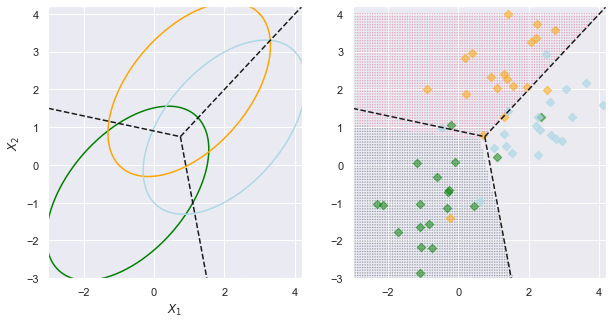

In [892]:
#Plotting
fig,ax = plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(2*el_1[0,:]+np.ones(1000,)*mu_1[0],2*el_1[1,:]+np.ones(1000,)*mu_1[1],c='green')
plt.plot(2*el_1[0,:]+np.ones(1000,)*mu_2[0],2*el_1[1,:]+np.ones(1000,)*mu_2[1],c='orange')
plt.plot(2*el_1[0,:]+np.ones(1000,)*mu_3[0],2*el_1[1,:]+np.ones(1000,)*mu_3[1],c='lightblue')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.xlim(-3,4.2)
plt.ylim(-3,4.2)
plt.plot(x2,y2,c='k',linestyle = '--')
plt.plot(x3,y3,c='k',linestyle = '--')
plt.plot(x1,y1,c='k',linestyle = '--')

plt.subplot(1,2,2)
plt.scatter(gridx,gridy,c=classification,alpha=0.5,s=0.1)
plt.scatter(pts0[:,0],pts0[:,1],c='green',marker='D',alpha=0.5)
plt.scatter(pts1[:,0],pts1[:,1],c='orange',marker='D',alpha=0.5)
plt.scatter(pts2[:,0],pts2[:,1],c='lightblue',marker='D',alpha=0.7)
plt.plot(x2,y2,c='k',linestyle = '--')
plt.plot(x3,y3,c='k',linestyle = '--')
plt.plot(x1,y1,c='k',linestyle = '--')
plt.xlim(-3,4.2)
plt.ylim(-3,4.2);


In the graphs above three classes of normally distributed sets are visualized. 20 observations are made from each class,which are plotted on the right hand side graph. The Bayes' decision boundary (dashed line) and Linear Distriminant Analaysis classifications (shaded regions) are shown. Note that the LDA decision boundary is a linear function of x.

Now lets use this method on the Default data that we used logistic regression on previously in this chapter.

We can calculate the confusion matrix for this approach, which tells us about the correct and incorrect assignments the regression method makes in all of the classes (2, in the default data case: either defaulted or not).

In [986]:
x1 = default[['balance']]
x2 = default[['student']].applymap(lambda x: yndict[x])
X = pd.concat([x1,x2],axis=1)
y = default[['default']].applymap(lambda x: yndict[x])


In [926]:
lda.fit(X,y['default'])
default_status = lda.predict(X)

from sklearn.metrics import confusion_matrix, classification_report
conf = confusion_matrix(y['default'],default_status)
print('Confusion matrix:')
print(conf) 


Confusion matrix:
[[9644   23]
 [ 252   81]]


The overall error rate is low (23+252)/10000 but, the error rate among those who defaulted is incredibly high! (252/(252+81)), showing that class-specific performance is highly variable. 

Concepts:

-sensitivity: percentage of defaulters correctly identified (24.3%)

-specificity: percentage of non-defaulters correctly identified (99.8%)

Maybe sensitivity is much more important than specificity in a certain situation (like in the case of the credit card company). In this case, we can tweak LDA. Since LDA approximates the Bayes classifier, and, for the case of two classes, assigns 'default' for $P($default = 'Yes' $|X=x) >0.5$, we can lower the threshold such that it assigns 'Yes' for probability >0.2.

In [987]:
lda.fit(X,y['default'])
default_prob = lda.predict_proba(X)
thres = 0.2
default_status = default_prob[:,1]
default_status[default_status<thres] = 0
default_status[default_status>thres] = 1

conf = confusion_matrix(y['default'],default_status)
print('Confusion matrix for 20% probability threshold:')
print(conf) 


Confusion matrix for 20% probability threshold:
[[9432  235]
 [ 138  195]]


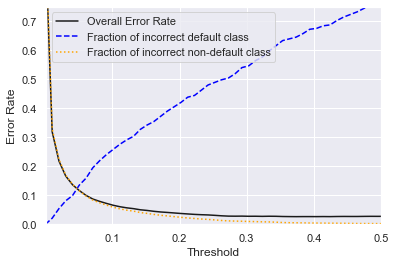

In [1010]:
thres = np.linspace(0,1,100)
error_rate = []
incorrect_default = []
incorrect_nondefault = []
correct_default = []

for t in thres:
    lda.fit(X,y['default'])
    default_prob = lda.predict_proba(X)
    default_status = default_prob[:,1]
    default_status[default_status<t] = 0
    default_status[default_status>t] = 1
    conf = confusion_matrix(y['default'],default_status)
    error_rate.append((conf[0,1]+conf[1,0])/10000)
    incorrect_default.append(conf[1,0]/np.sum(conf[1,:]))
    incorrect_nondefault.append(conf[0,1]/np.sum(conf[0,:]))
    correct_default.append(conf[1,1]/np.sum(conf[1,:]))

plt.plot(thres,error_rate,c='k',label='Overall Error Rate')
plt.plot(thres,incorrect_default,c='blue',linestyle='--',label='Fraction of incorrect default class')
plt.plot(thres,incorrect_nondefault,c='orange',linestyle=':',label='Fraction of incorrect non-default class')
plt.legend()
plt.xlim(0.001,0.5)
plt.ylim(0,0.75)
plt.xlabel('Threshold')
plt.ylabel('Error Rate');

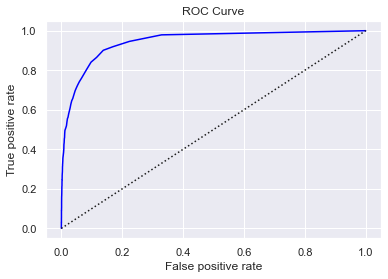

In [1011]:
plt.plot(incorrect_nondefault,correct_default,c='blue')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),c='k',linestyle=':')
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

The overall performance of a classifier is given by the area under the ROC curve, the larger the better. 

In [1022]:
xes = np.array(incorrect_nondefault[1:])-np.array(incorrect_nondefault[:-1])
area = np.sum(-xes*np.array(correct_default[:-1]))
print(area)


0.9555619548378418


#### Quadratic discriminant analysis

In QDA, we relax the assumption of equal covariance such that $X \sim N(\mu_k,\Sigma_k)$. So, this method labels the observation to the class for which the below equation is maximal:

$$ \delta_k(x) = -\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1}(x-\mu_k)-\frac{1}{2} log|\Sigma_k|+log \pi_k $$

Unlike LDA, the equation for QDA is quadratic in $x$.


#### Naive Bayes

Instead of making assumptions about the distribution of $X$, we make a single, independence assumption: That within each class, the predictors are all independent, which means that for each class k

$$ f_k(x) = f_{k1}(x_1) \times ... \times f_{kp}(x_p), $$

where $f_{kj}$ is the density function of the jth predictor for observations belonging to class k.